In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.colors import rgb2hex
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
matplotlib.style.use('ggplot')
from mpl_toolkits.mplot3d.axes3d import Axes3D
import h2o
import random
from sklearn import metrics
import math
import operator
import scipy.optimize as op
import scipy.io as sio
import pickle

In [2]:
# IMPORT DATA
filepath1 = '/Path/Behavioral_Risk_Factor_Surveillance_System__BRFSS__Age-Adjusted_Prevalence_Data__2011_to_present_.csv'
filepath2 = '/Path/brfss2014.csv'
df_brss1 = pd.read_csv(filepath1, sep = ',')
df_brss2 = pd.read_csv(filepath2, sep = ',')

/Users/rekha/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_brss1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22154 entries, 0 to 22153
Data columns (total 27 columns):
Year                          22154 non-null int64
Locationabbr                  22154 non-null object
Locationdesc                  22154 non-null object
Class                         22154 non-null object
Topic                         22154 non-null object
Question                      22154 non-null object
Response                      22154 non-null object
Break_Out                     22154 non-null object
Break_Out_Category            22154 non-null object
Sample_Size                   22154 non-null int64
Data_value                    22109 non-null float64
Confidence_limit_Low          22109 non-null float64
Confidence_limit_High         22109 non-null float64
Display_order                 22154 non-null float64
Data_value_unit               22154 non-null object
Data_value_type               22154 non-null object
Data_Value_Footnote_Symbol    0 non-null float64
Data_Val

In [4]:
df_brss2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464664 entries, 0 to 464663
Columns: 280 entries, Unnamed: 0 to rcsbirth
dtypes: float64(226), int64(53), object(1)
memory usage: 992.6+ MB


In [5]:
# GET A SENSE OF THE TOPICS
topic_list = pd.unique(df_brss1['Topic'].ravel())
num_topics = len(topic_list)
State_list = pd.unique(df_brss1['Locationdesc'].ravel())
num_states = len(topic_list)
year_list = pd.unique(df_brss1['Year'].ravel())

In [6]:
topic_list

/Users/rekha/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/rekha/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


array(['Depression', 'Disability status', 'COPD', 'Kidney', 'Other Cancer',
       'Skin Cancer', 'Cardiovascular Disease', 'Alcohol Consumption',
       'HIV Test', 'Health Care Coverage', 'Internet', 'Health Care Cost',
       'Shingle Vaccination', 'Veteran Status', 'All Teeth Removed',
       'Asthma', 'USPSTF Recommendations', 'Dental Visit', 'Arthritis',
       'Teeth Removed', 'Flu Shot', 'Under 65 Coverage', 'Mammogram',
       'Pneumonia Vaccination', 'Binge Drinking', 'Blood Stool Test',
       'Heavy Drinking', 'Fair or Poor Health', 'Pap Test', 'PSA Test',
       'Seatbelt Use', 'Sigmoidoscopy', 'Current Smoker Status',
       'Exercise', 'Personal Care Provider', 'Smokeless Tobacco',
       'Diabetes', 'BMI Categories', 'Smoker Status', 'Last Checkup',
       'Overall Health', 'Cholesterol Checked', 'Fruit Consumption',
       'Physical Activity Index', 'Aerobic Activity', 'Strength Activity',
       'Cholesterol High', 'High Blood Pressure', 'Vegetable Consumption',
     

In [7]:
# MAKE SOME PLOTS SHOWING DISTRIBUTION ACROSS THE US

In [8]:
def plot_maps(df, year, topic, response, value_term, title_term, colname, State_list) :
    
    # Part of the map-plotting code derived from https://github.com/matplotlib/basemap/tree/master/examples 
    
    plt.figure(figsize=(16,8))
    m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
                projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
    shape_info = m.readshapefile('/Users/rekha/anaconda/pkgs/maps/st99_d00','states',drawbounds=True)
    colors={}
    color_list = []
    statenames=[]
    patches = []
    populations = {}
    cmap = plt.cm.hot # use 'hot' colormap
    
    # pull relevant data by state
    for statename in State_list:
        pop = round(df.loc[(df['Year'] == year) & (df['Locationdesc'] == statename) & (df['Topic'] == topic) 
                & (df['Response'] == response)][value_term].values[0], 2)
        populations[statename] = pop
    pop_df = pd.DataFrame.from_dict(populations, orient='index', dtype='float64')
    pop_df.columns = [colname]
    
    # determine range for plotting data
    vmin = pop_df[colname].min()
    vmax = pop_df[colname].max()
    added_buffer = 0.1*(vmax - vmin)
    if (vmin - added_buffer) < 0:
        vmin = 0
    else: 
        vmin = math.floor(vmin - added_buffer)
    if (vmax + added_buffer) > 100:
        vmax = 100
    else:
        vmax = math.ceil(vmax + added_buffer)
        
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        pop = populations[statename]
        colors[statename] = cmap(1.0 - (pop-vmin)/(vmax-vmin))
        statenames.append(statename)
        color_list.append(colors[statename])

    # cycle through state names, color each one.
    ax = plt.gca() # get current axes instance
    for nshape,seg in enumerate(m.states):
        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        patches.append(poly)
        ax.add_patch(poly)

    p = PatchCollection(patches, cmap = cmap)
    p.set_array(np.array(color_list))
    cb = m.colorbar(p, ticks = np.arange(-0.1,1, 0.1) )
    cb.ax.invert_yaxis() 
    cb.set_ticklabels(vmin + (vmax - vmin)*np.arange(1,-0.1, -0.1))

    # draw meridians and parallels.
    m.drawparallels(np.arange(25,65,20),labels=[1,0,0,0])
    m.drawmeridians(np.arange(-120,-40,20),labels=[0,0,0,1])
    plt.title(title_term)
    plt.show()
    return pop_df

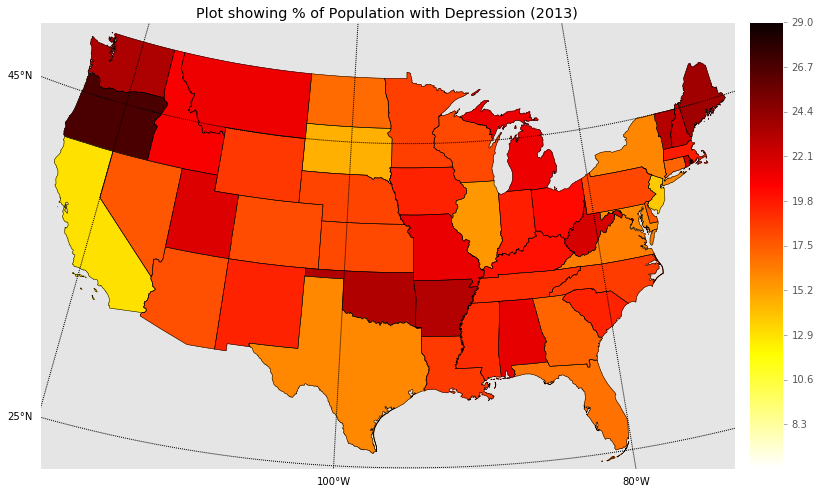

In [9]:
year = 2013
topic = 'Depression'
response = 'Yes'
value_term = 'Data_value'
title_term = 'Plot showing % of Population with Depression (2013)'
colname = 'Depression_2013'
depression_2013 = plot_maps(df_brss1, year, topic, response, value_term, title_term, colname, State_list)

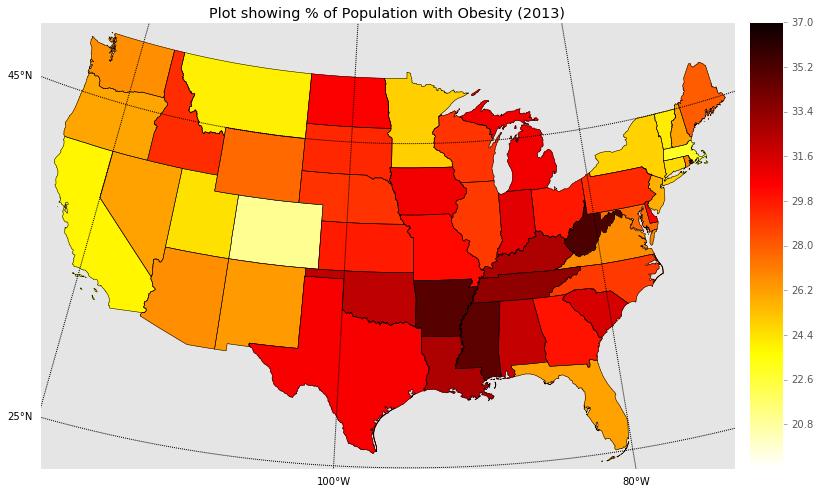

In [10]:
year = 2013
topic = 'BMI Categories'
response = 'Obese (BMI 30.0 - 99.8)'
value_term = 'Data_value'
title_term = 'Plot showing % of Population with Obesity (2013)'
colname = 'Obese_2013'
Obese_2013 = plot_maps(df_brss1, year, topic, response, value_term, title_term, colname, State_list)

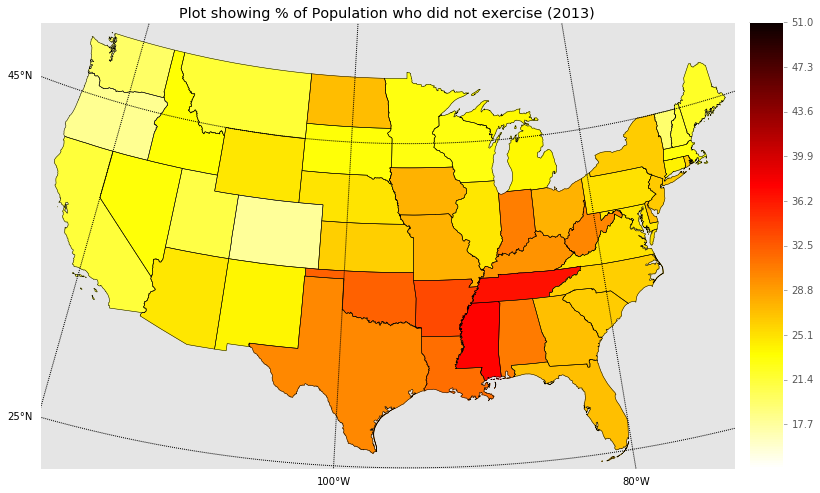

In [11]:
year = 2013
topic = 'Exercise'
response = 'No'
value_term = 'Data_value'
title_term = 'Plot showing % of Population who did not exercise (2013)'
colname = 'No_exercise_2013'
No_exercise_2013 = plot_maps(df_brss1, year, topic, response, value_term, title_term, colname, State_list)

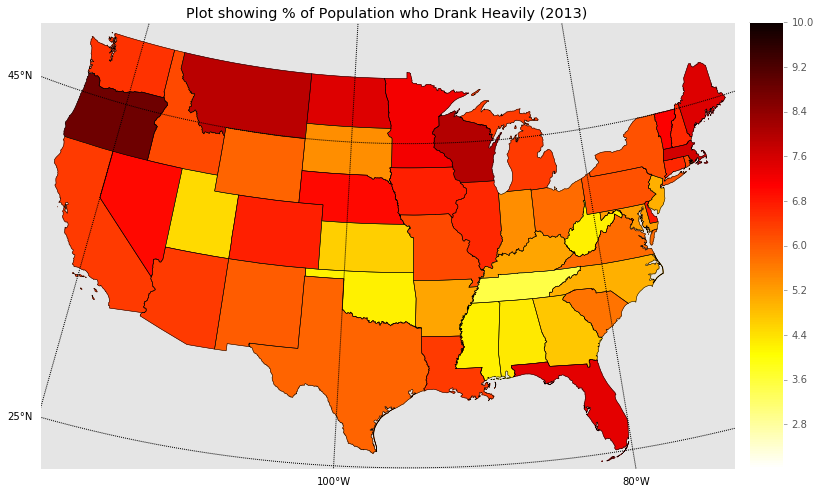

In [12]:
year = 2013
topic = 'Heavy Drinking'
response = 'Yes'
value_term = 'Data_value'
title_term = 'Plot showing % of Population who Drank Heavily (2013)'
colname = 'Alcohol_heavy_2013'
Alcohol_heavy_2013 = plot_maps(df_brss1, year, topic, response, value_term, title_term, colname, State_list)

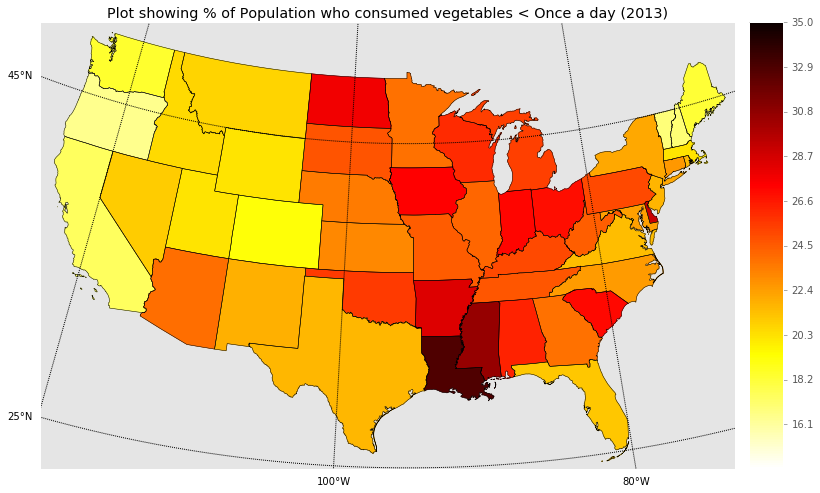

In [13]:
year = 2013
topic = 'Vegetable Consumption'
response = 'Less than one time per day'
value_term = 'Data_value'
title_term = 'Plot showing % of Population who consumed vegetables < Once a day (2013)'
colname = 'Vegetable_consumption_2013'
Vegetable_consumption_2013 = plot_maps(df_brss1, year, topic, response, value_term, title_term, colname, State_list)

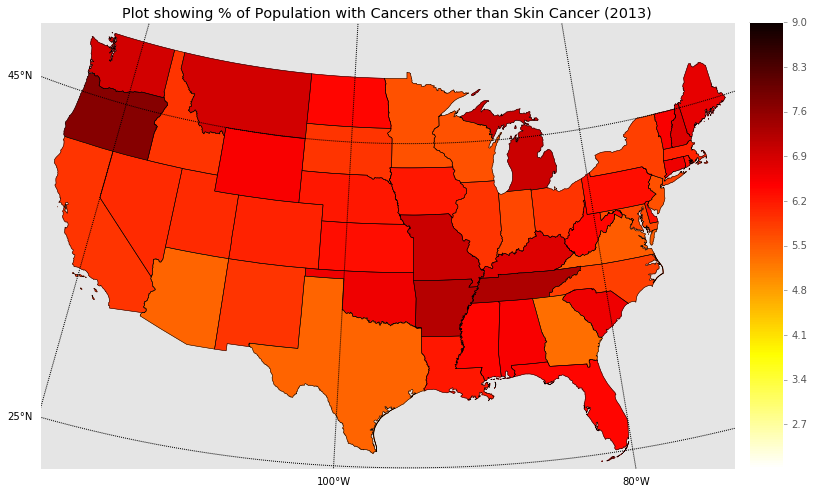

In [14]:
year = 2013
topic = 'Other Cancer'
response = 'Yes'
value_term = 'Data_value'
title_term = 'Plot showing % of Population with Cancers other than Skin Cancer (2013)'
colname = 'Other_cancer_2013'
Other_cancer_2013 = plot_maps(df_brss1, year, topic, response, value_term, title_term, colname, State_list)

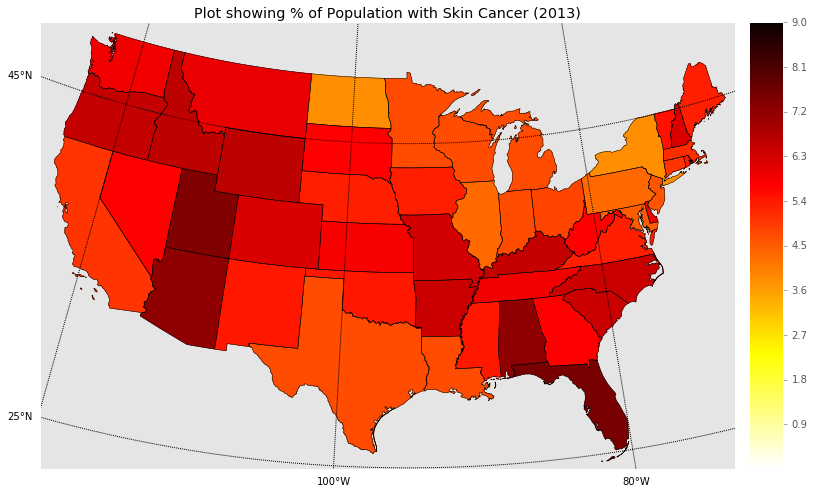

In [15]:
year = 2013
topic = 'Skin Cancer'
response = 'Yes'
value_term = 'Data_value'
title_term = 'Plot showing % of Population with Skin Cancer (2013)'
colname = 'Skin_cancer_2013'
Skin_cancer_2013 = plot_maps(df_brss1, year, topic, response, value_term, title_term, colname, State_list)

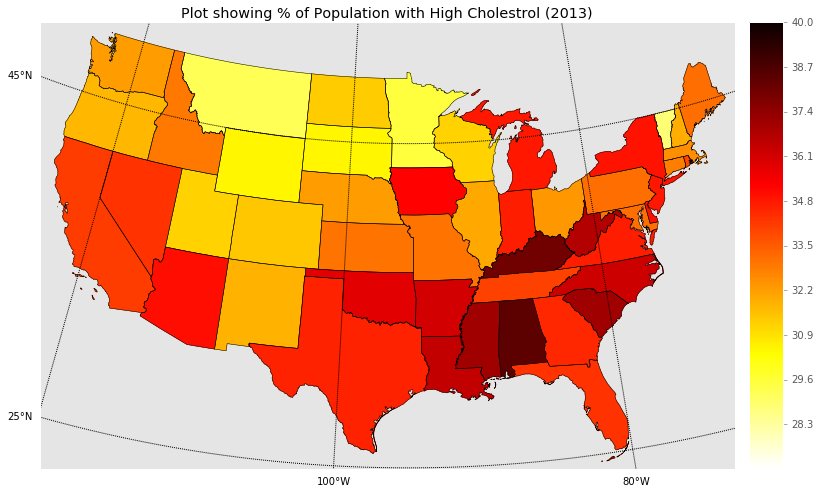

In [16]:
year = 2013
topic = 'Cholesterol High'
response = 'Yes'
value_term = 'Data_value'
title_term = 'Plot showing % of Population with High Cholestrol (2013)'
colname = 'Cholestrol_2013'
cholestrol_2013 = plot_maps(df_brss1, year, topic, response, value_term, title_term, colname, State_list)

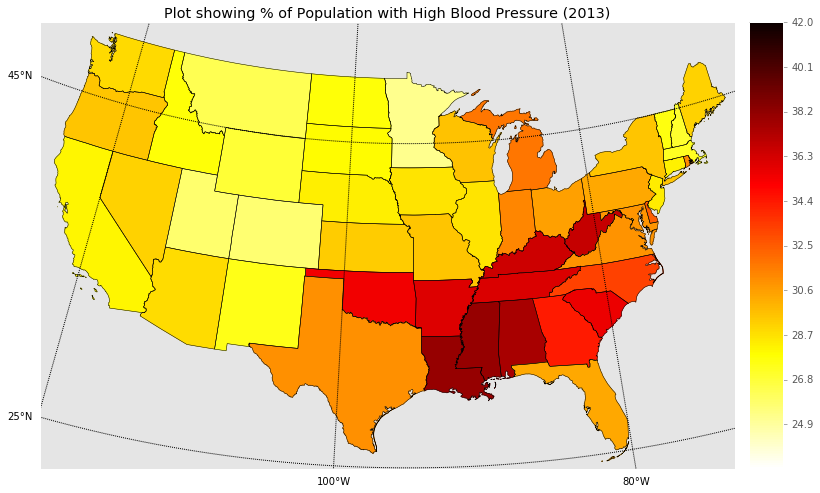

In [17]:
year = 2013
topic = 'High Blood Pressure'
response = 'Yes'
value_term = 'Data_value'
title_term = 'Plot showing % of Population with High Blood Pressure (2013)'
colname = 'BP_2013'
BP_2013 = plot_maps(df_brss1, year, topic, response, value_term, title_term, colname, State_list)

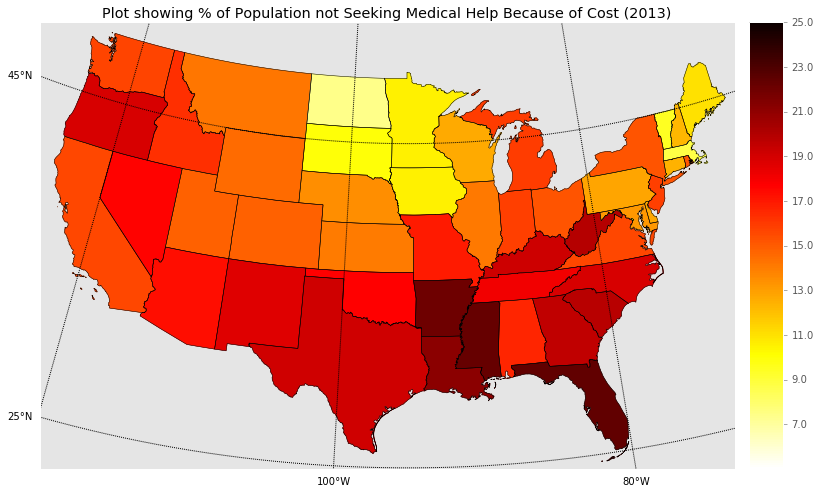

In [18]:
year = 2013
topic = 'Health Care Cost'
response = 'Yes'
value_term = 'Data_value'
title_term = 'Plot showing % of Population not Seeking Medical Help Because of Cost (2013)'
colname = 'Healthcare_cost_2013'
healthcare_cost_2013 = plot_maps(df_brss1, year, topic, response, value_term, title_term, colname, State_list)

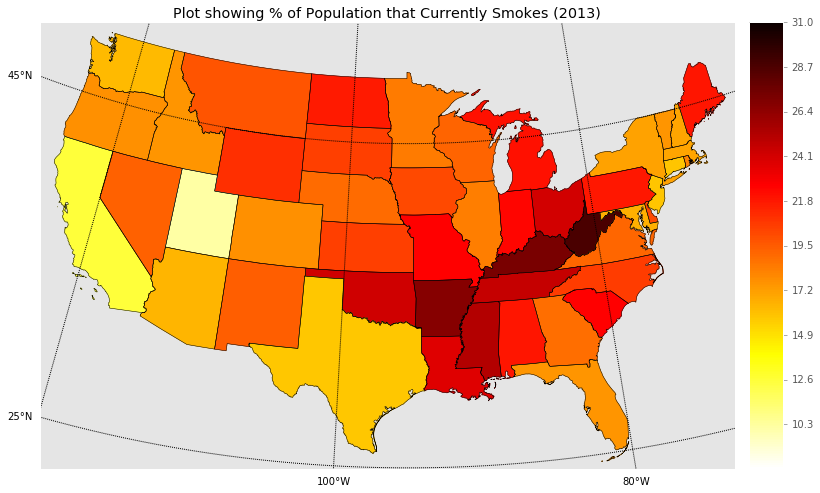

In [19]:
year = 2013
topic = 'Current Smoker Status'
response = 'Yes'
value_term = 'Data_value'
title_term = 'Plot showing % of Population that Currently Smokes (2013)'
colname = 'Smoke_occasionally_2013'
current_smoker_2013 = plot_maps(df_brss1, year, topic, response, value_term, title_term, colname, State_list)

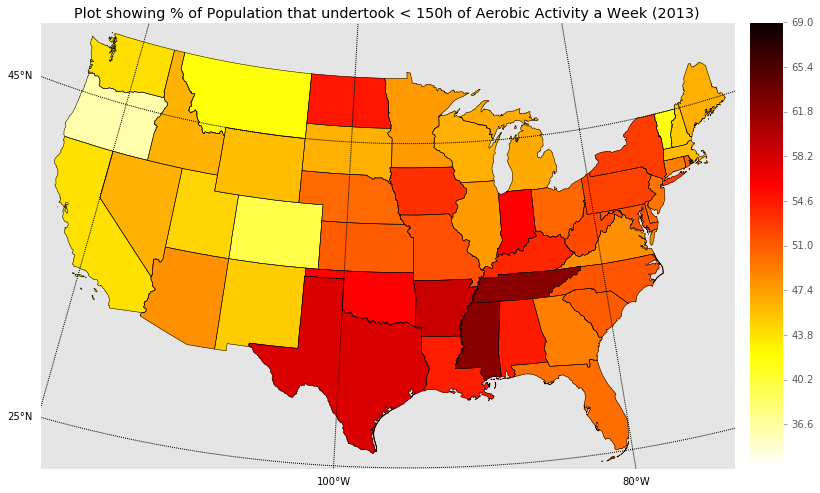

In [20]:
year = 2013
topic = 'Physical Activity Index'
response = 'No'
value_term = 'Data_value'
title_term = 'Plot showing % of Population that undertook < 150h of Aerobic Activity a Week (2013)'
colname = 'phys_act_2013'
phys_act_2013 = plot_maps(df_brss1, year, topic, response, value_term, title_term, colname, State_list)

In [21]:
# COMBINE THE AGGREGATED RISK FACTORS INTO ONE DATAFRAME TO MAKE A SIMPLE, OVERVIEW REGRESSION MODEL
frames = [depression_2013, Obese_2013, No_exercise_2013, Alcohol_heavy_2013, Vegetable_consumption_2013, 
          Other_cancer_2013, Skin_cancer_2013, cholestrol_2013, BP_2013, healthcare_cost_2013, current_smoker_2013, 
          phys_act_2013]
data_2013 = pd.concat(frames, axis = 1)

In [ ]:
# CREATE LINEAR REGRESSION MODEL 
# CANCER WITH RISK FACTORS (ALL AGGREGATED AT STATE LEVEL)
# THIS IS A FIRST PASS LOOK AT THE DATA BEFORE PROCEEDING TO A MORE DETAILED ANALYSIS USING df_brss2 DATA.

In [22]:
h2o.init()

H2O cluster uptime:,5 days 4 minutes 9 seconds 763 milliseconds
H2O cluster version:,3.2.0.9
H2O cluster name:,H2O_started_from_python
H2O cluster total nodes:,1
H2O cluster total memory:,910.5 MB
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321


In [23]:
# Convert Dataframe to Hex format for H2O
keys = list(data_2013.keys())
temp_dic = {}
for key in keys:
    temp_data = list(data_2013[key].values)
    temp_dic.update({key:temp_data})
data_hex = h2o.H2OFrame(temp_dic, column_names = keys)

response_key = 'Other_cancer_2013'
keys.remove(response_key)
keys.remove('Skin_cancer_2013')


Parse Progress: [##################################################] 100%
Uploaded py6712781a-d7c3-4fec-a6e9-90b34b773d27 into cluster with 53 rows and 12 cols


In [31]:
# Randomly select training and validation (test) splits
random_idx = data_hex[response].runif(seed = 1234)
train_hex = data_hex[random_idx >= 0.2]
test_hex = data_hex[random_idx < 0.2]
features = keys
response = [response_key]

In [32]:
# Build Model using H2O
params_model = {'x': features, 'y': response,
               'training_frame': train_hex,
               'validation_frame': test_hex,
               'family': 'gaussian',
               'link': 'identity', 'lambda_search': 'True'}
glm_model = h2o.glm(**params_model)


glm Model Build Progress: [##################################################] 100%


In [33]:
# Display model
glm_model

Model Details
H2ORegressionModel :  Generalized Linear Model
Model Key:  GLM_model_python_1468428963815_48
       family      link                               regularization  \
0    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.1178 )   

                                       lambda_search  \
0  nlambda = 100, lambda_max = 1.1509, best_lambd...   

   number_of_predictors_total  number_of_active_predictors  \
0                          10                            6   

   number_of_iterations                          training_frame  
0                    52  py7ac69017-097a-4869-bc0e-e8cf230b9194  


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.277227945944
R^2: 0.609194289807
Mean Residual Deviance: 0.277227930217
Null degrees of freedom: 40
Residual degrees of freedom: 35
Null deviance: 29.0843902439
Residual deviance: 11.3663451389
AIC: 77.7534341291

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.104191093652
R^2: 0

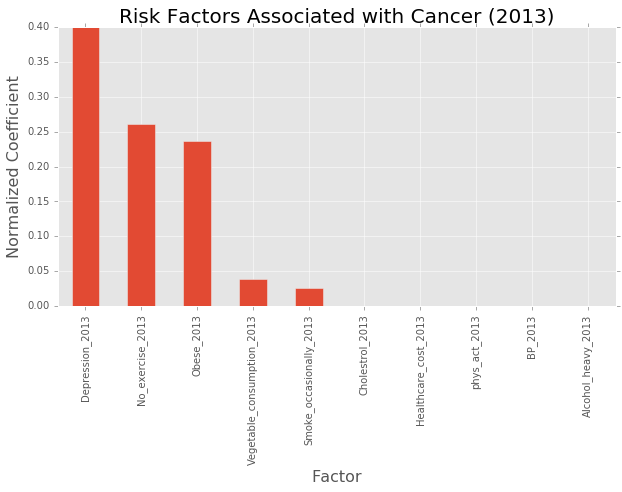

In [34]:
# COEFFICIENTS
coeffs = glm_model.coef_norm()
del coeffs['Intercept']
coeffs_df = pd.DataFrame(coeffs.values(), index = list(coeffs.keys()), columns = ['feature'])
coeffs_df['feature_abs'] = coeffs_df.abs()
coeffs_df = coeffs_df.sort_values(by = 'feature_abs', ascending = False)
# PLOT
fig = plt.figure(figsize=(10,5))
coeffs_df['feature_abs'].plot(kind='bar')
plt.xlabel('Factor', fontsize=16)
plt.ylabel('Normalized Coefficient', fontsize=16)
plt.title('Risk Factors Associated with Cancer (2013)', fontsize = 20)

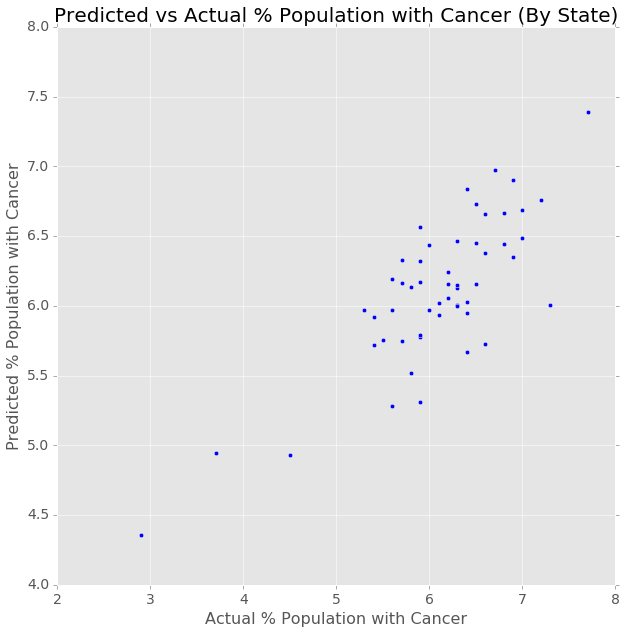

In [35]:
# SCATTER PLOT OF PREDICTED VS ACTUAL
pred = glm_model.predict(data_hex)
y_hat_DF = h2o.as_list(pred)
y_DF = h2o.as_list(data_hex[response_key])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(y_DF[response_key], y_hat_DF['predict'])
plt.xlabel('Actual % Population with Cancer', fontsize=16)
plt.ylabel('Predicted % Population with Cancer', fontsize=16)
plt.title('Predicted vs Actual % Population with Cancer (By State)', fontsize = 20)
plt.tick_params(labelsize=14)
plt.show()